In [1]:
import torch
import numpy as np
import skimage.io
import skimage
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import random
import itertools
import pickle
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [2]:
train_X = np.load("all_img.npy")
train_X = torch.from_numpy(train_X).type(torch.FloatTensor)

In [3]:
# fixed input
fixed_z = []
for _ in range(5):
    z = torch.randn((1, 62)).repeat(10,1)
    fixed_z.append(z)
fixed_z = torch.cat(fixed_z)
c = torch.zeros(10,10)
c[[range(10)],[range(10)]] = 1
c = c.repeat(5,1)

fixed_input = torch.cat((fixed_z, c),1).view(50,72,1,1)
print(fixed_input.size())
fixed_input = Variable(fixed_input).cuda()

torch.Size([50, 72, 1, 1])


In [4]:
class Generator(nn.Module):
    def __init__(self, figsize=64):
        super(Generator, self).__init__()
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 62+10, figsize * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(figsize * 8),
            nn.ReLU(inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(figsize * 8, figsize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 4),
            nn.ReLU(inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(figsize * 4, figsize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 2),
            nn.ReLU(inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(figsize * 2, figsize, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize),
            nn.ReLU(inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(figsize, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, X):
        output = self.decoder(X)/2.0+0.5
        return output

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        figsize = 64
        self.conv_decoder = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, figsize, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(figsize, figsize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(figsize * 2, figsize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(figsize * 4, figsize * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
                    
        self.D_out = nn.Sequential(
            nn.Conv2d(figsize * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.Q_out = nn.Sequential(
            nn.Linear(8192, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 10),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv_decoder(x)
        encode_output_size = x.size()
#         print("conv encode size:",x.size()) # (batch_size, 512,4,4)
        real_fake = self.D_out(x).view(-1, 1)
        x = x.view(-1, 512*4*4)
        discrete = self.Q_out(x)
        return real_fake, discrete

In [5]:
BATCH_SIZE = 64
G = Generator().cuda()
D = Discriminator().cuda()

BCE_loss = nn.BCELoss().cuda()
CE_loss = nn.CrossEntropyLoss().cuda()

# setup optimizer
optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerInfo = optim.Adam(itertools.chain(G.parameters(), D.parameters()), 
                           lr=0.0002, betas=(0.5, 0.999))

D_loss_list = []
G_loss_list = []
D_fake_acc_list = []
D_real_acc_list = []
Info_loss_list = []
for epoch in range(200):
    print("Epoch:", epoch+1)
    epoch_D_loss = 0.0
    epoch_G_loss = 0.0
    D_fake_acc = 0.0
    D_real_acc = 0.0
    epoch_Info_loss = 0.0
    total_length = len(train_X)
    # shuffle
    perm_index = torch.randperm(total_length)
    train_X_sfl = train_X[perm_index]
    # learning rate decay
    if (epoch+1) == 50:
        optimizerG.param_groups[0]['lr'] /= 2
        optimizerD.param_groups[0]['lr'] /= 2
        optimizerInfo.param_groups[0]['lr'] /= 2
        print("learning rate change!")

    if (epoch+1) == 80:
        optimizerG.param_groups[0]['lr'] /= 2
        optimizerD.param_groups[0]['lr'] /= 2
        optimizerInfo.param_groups[0]['lr'] /= 2
        print("learning rate change!")
        
    # construct training batch
    for index in range(0,total_length ,BATCH_SIZE):
        if index+BATCH_SIZE > total_length:
            break
            
        # zero the parameter gradients
        D.zero_grad()
        input_X = train_X_sfl[index:index+BATCH_SIZE]
        
        #### train with real image -> ground truth = real label
        real_image = Variable(input_X.cuda()) # use GPU 
        real_label = Variable(torch.ones((BATCH_SIZE))).cuda()
        output, disc_output = D(real_image)
        D_real_loss = BCE_loss(output, real_label)
        D_real_acc += np.mean(((output > 0.5).cpu().data.numpy() == real_label.cpu().data.numpy()))
        
        #### train with fake image -> ground truth = fake label
        z_ = torch.randn((BATCH_SIZE, 62,1,1))
        c1 = np.random.multinomial(1, 10 * [float(1.0 /10)], size=[BATCH_SIZE])
        c1 = torch.from_numpy(c1).type(torch.FloatTensor).view(BATCH_SIZE,10,1,1)
        combine_input = Variable(torch.cat((z_, c1),1)).cuda()
        
        fake_image = G(combine_input)
        fake_label = Variable(torch.zeros((BATCH_SIZE))).cuda()
        output, disc_output = D(fake_image)
        D_fake_loss = BCE_loss(output, fake_label)
        D_fake_acc += np.mean(((output > 0.5).cpu().data.numpy() == fake_label.cpu().data.numpy()))
        
        # update D
        D_train_loss = D_real_loss + D_fake_loss
        epoch_D_loss+=(D_train_loss.data[0])
        D_train_loss.backward(retain_graph=True)
        optimizerD.step()
        
        #### train Generator
        G.zero_grad()
        # generate fake image
        z_ = torch.randn((BATCH_SIZE, 62,1,1))
        c1 = np.random.multinomial(1, 10 * [float(1.0 /10)], size=[BATCH_SIZE])
        c1 = torch.from_numpy(c1).type(torch.FloatTensor).view(BATCH_SIZE,10,1,1)
        combine_input = Variable(torch.cat((z_, c1),1)).cuda()
        c1 = Variable(c1).cuda()
        
        fake_image = G(combine_input)
        fake_label_for_G = Variable(torch.ones((BATCH_SIZE))).cuda()
        output, disc_output = D(fake_image)
        G_loss = BCE_loss(output, fake_label_for_G)
        epoch_G_loss += (G_loss.data[0])
        G_loss.backward(retain_graph=True)
        optimizerG.step()
        
        # information loss
        disc_loss = CE_loss(disc_output,torch.max(c1.view(BATCH_SIZE,-1),1)[1])
        epoch_Info_loss += (disc_loss.data[0])
        disc_loss.backward()
        optimizerInfo.step()
        
    print("training D Loss:",epoch_D_loss/(total_length))
    print("training G Loss:", epoch_G_loss/(total_length))
    print("training Info Loss:", epoch_Info_loss/(total_length))
    D_loss_list.append(epoch_D_loss/(total_length))
    G_loss_list.append(epoch_G_loss/(total_length))
    Info_loss_list.append(epoch_Info_loss/(total_length))
    
    print("D_real_acc:", D_real_acc/(total_length/BATCH_SIZE))
    print("D_fake_acc:", D_fake_acc/(total_length/BATCH_SIZE))
    
    D_real_acc_list.append(D_real_acc/(total_length/BATCH_SIZE))
    D_fake_acc_list.append(D_fake_acc/(total_length/BATCH_SIZE))
    # evaluation
    G.eval()
    fixed_img_output = G(fixed_input)
    G.train()
    torchvision.utils.save_image(fixed_img_output.cpu().data, './InfoGAN_output/figB_'+str(epoch+1)+'.jpg',nrow=10)
    
torch.save(G.state_dict(), "./models/InfoG_model.pkt")

Epoch: 1


/home/thtang/.local/lib/python3.5/site-packages/torch/nn/functional.py:1189: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


training D Loss: 0.021711906970647878
training G Loss: 0.012782432877142817
training Info Loss: 0.028045404810719852
D_real_acc: 0.9863916848501912
D_fake_acc: 0.04026184275357218
Epoch: 2
training D Loss: 0.022171799819558562
training G Loss: 0.011413192767763078
training Info Loss: 0.023694966464842482
D_real_acc: 0.9894652870650619
D_fake_acc: 0.006757232350249877
Epoch: 3
training D Loss: 0.022287729129320026
training G Loss: 0.010924356946056651
training Info Loss: 0.02316322625319689
D_real_acc: 0.992867365852514
D_fake_acc: 0.005771802632505103
Epoch: 4
training D Loss: 0.022132753089609783
training G Loss: 0.011032524219590448
training Info Loss: 0.02303889779157807
D_real_acc: 0.9918584735224419
D_fake_acc: 0.006968395861195185
Epoch: 5
training D Loss: 0.02217771570886312
training G Loss: 0.01094894328235626
training Info Loss: 0.0229971276435844
D_real_acc: 0.9909903568663335
D_fake_acc: 0.010065460688393046
Epoch: 6
training D Loss: 0.022150216049234075
training G Loss: 0.0

training D Loss: 0.018267588075771758
training G Loss: 0.014472865452248086
training Info Loss: 0.022880966560823994
D_real_acc: 0.9887379460829169
D_fake_acc: 0.2660660237910889
Epoch: 46
training D Loss: 0.018230196967934605
training G Loss: 0.014440642702442727
training Info Loss: 0.022886016740246495
D_real_acc: 0.9878932920391357
D_fake_acc: 0.27247131695642995
Epoch: 47
training D Loss: 0.01803453027585327
training G Loss: 0.014711643850637515
training Info Loss: 0.022890285101845567
D_real_acc: 0.9882686938363717
D_fake_acc: 0.2849065014898759
Epoch: 48
training D Loss: 0.018092556582754483
training G Loss: 0.01478113683899392
training Info Loss: 0.022877370255894227
D_real_acc: 0.9869078623213908
D_fake_acc: 0.2845310996926398
Epoch: 49
training D Loss: 0.017859603228365075
training G Loss: 0.014806509665440887
training Info Loss: 0.022881433698120245
D_real_acc: 0.9873301893432814
D_fake_acc: 0.3028084746955726
Epoch: 50
learning rate change!
training D Loss: 0.016654065714457

training D Loss: 0.013664832136654002
training G Loss: 0.015429547606901595
training Info Loss: 0.022881541750330987
D_real_acc: 0.9957767297810938
D_fake_acc: 0.6320827760962906
Epoch: 90
training D Loss: 0.013685336113479527
training G Loss: 0.01538060400683514
training Info Loss: 0.022884213670723564
D_real_acc: 0.9953778653715305
D_fake_acc: 0.6337016963468712
Epoch: 91
training D Loss: 0.01365420999907588
training G Loss: 0.015491306114693518
training Info Loss: 0.0228715025778124
D_real_acc: 0.9955890288824758
D_fake_acc: 0.6340770981441074
Epoch: 92
training D Loss: 0.013627742523069756
training G Loss: 0.015581733617533998
training Info Loss: 0.022879045862294674
D_real_acc: 0.9960348185166936
D_fake_acc: 0.6338190094085075
Epoch: 93
training D Loss: 0.013571312786035258
training G Loss: 0.015557501838039483
training Info Loss: 0.022880645296249807
D_real_acc: 0.995518641045494
D_fake_acc: 0.6363060463151967
Epoch: 94
training D Loss: 0.013512398057925852
training G Loss: 0.015

training D Loss: 0.012942775432603854
training G Loss: 0.01666465551077135
training Info Loss: 0.022890998696187832
D_real_acc: 0.996527533375566
D_fake_acc: 0.6649773585791042
Epoch: 134
training D Loss: 0.012963460953197978
training G Loss: 0.016679282194960416
training Info Loss: 0.022883924680286355
D_real_acc: 0.9966213838248751
D_fake_acc: 0.6650946716407404
Epoch: 135
training D Loss: 0.012934498056248087
training G Loss: 0.016758380275825307
training Info Loss: 0.0228835888547314
D_real_acc: 0.9964102203139298
D_fake_acc: 0.6656577743365947
Epoch: 136
training D Loss: 0.012902974797107404
training G Loss: 0.016747999602717195
training Info Loss: 0.022878660060634378
D_real_acc: 0.996433682926257
D_fake_acc: 0.6654700734379766
Epoch: 137
training D Loss: 0.012863809775272395
training G Loss: 0.01671500647046487
training Info Loss: 0.022880200092724432
D_real_acc: 0.9965509959878933
D_fake_acc: 0.6679336477323385
Epoch: 138
training D Loss: 0.012912368144258671
training G Loss: 0

training D Loss: 0.012617038332625284
training G Loss: 0.017135127236659012
training Info Loss: 0.022882544102962667
D_real_acc: 0.9971375612960747
D_fake_acc: 0.6778114075221136
Epoch: 178
training D Loss: 0.012688757674243918
training G Loss: 0.017218702542211528
training Info Loss: 0.022883385736601453
D_real_acc: 0.9968325473358204
D_fake_acc: 0.6707726238239365
Epoch: 179
training D Loss: 0.012657648931767195
training G Loss: 0.01713187362662127
training Info Loss: 0.022886536110795896
D_real_acc: 0.9966683090495295
D_fake_acc: 0.6759109359236057
Epoch: 180
training D Loss: 0.01257883819672624
training G Loss: 0.017209863611535335
training Info Loss: 0.022883858641232005
D_real_acc: 0.9969498603974567
D_fake_acc: 0.6778348701344408
Epoch: 181
training D Loss: 0.012618620561072694
training G Loss: 0.017248204480739972
training Info Loss: 0.02288990127483998
D_real_acc: 0.9969733230097839
D_fake_acc: 0.6768025151920415
Epoch: 182
training D Loss: 0.012645963657993408
training G Loss

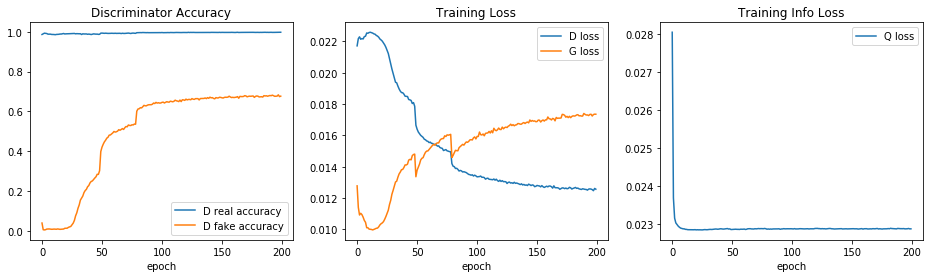

In [9]:
# with open("InfoGAN_D_real_acc_list.pkl","wb") as f:
#     pickle.dump(D_real_acc_list,f)
# with open("InfoGAN_D_fake_acc_list.pkl","wb") as f:
#     pickle.dump(D_fake_acc_list,f)
# with open("InfoGAN_D_loss_list.pkl","wb") as f:
#     pickle.dump(D_loss_list,f)
# with open("InfoGAN_G_loss_list.pkl","wb") as f:
#     pickle.dump(D_real_acc_list,f)
    
# plot loss
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(D_real_acc_list, label = "D real accuracy")
plt.plot(D_fake_acc_list, label = "D fake accuracy")
plt.title("Discriminator Accuracy")
plt.xlabel("epoch")
plt.legend()

plt.subplot(1,3,2)
plt.plot(D_loss_list, label="D loss")
plt.plot(G_loss_list, label="G loss")
plt.title("Training Loss")
plt.xlabel("epoch")
plt.legend()

plt.subplot(1,3,3)
plt.plot(Info_loss_list, label="Q loss")
plt.title("Training Info Loss")
plt.xlabel("epoch")
plt.legend()
plt.savefig("./InfoGAN_output/figB_2.jpg")
plt.show()